In [1]:
import copy
import itertools
import numpy as np
import h5py
import scipy
import sys
import tqdm
import verdict
import os
import unyt

In [2]:
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import palettable

In [3]:
import kalepy as kale

In [4]:
import galaxy_dive.analyze_data.halo_data as halo_data
import galaxy_dive.plot_data.plotting as plotting

In [5]:
from py2tex import py2tex

In [6]:
import trove
import trove.config_parser

# Load Data

In [7]:
config_fp = '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove'
cp = trove.config_parser.ConfigParser( config_fp )
pm = trove.link_params_to_config(
    config_fp,
    variation = 'm12i_md',
)

In [8]:
data_filepath = os.path.join( pm['processed_data_dir'], 'summary.hdf5' )
data = verdict.Dict.from_hdf5( data_filepath )

In [9]:
h_param = .702

In [10]:
mvir = verdict.Dict({})
mstar = verdict.Dict({})
for key in tqdm.tqdm( cp.variations ):
    
    pm_i = trove.link_params_to_config(
        '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove',
        variation = key,
    )
    
    h_data = halo_data.HaloData(
        data_dir = pm_i['halo_data_dir'],
        mt_kwargs = { 'tag': 'smooth' },
    )
    
    mvir[key] =  h_data.get_mt_data( 'Mvir', snums=[600] )[0]/h_param
    mstar[key] = h_data.get_mt_data( 'M_star', snums=[600] )[0]/h_param

100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


# Plot PDFs

In [11]:
sims_to_plot = [ [ 'm12i_md', 'm12b_md', ], [ 'm12c_md', 'm11d_md' ] ]

## Vertical

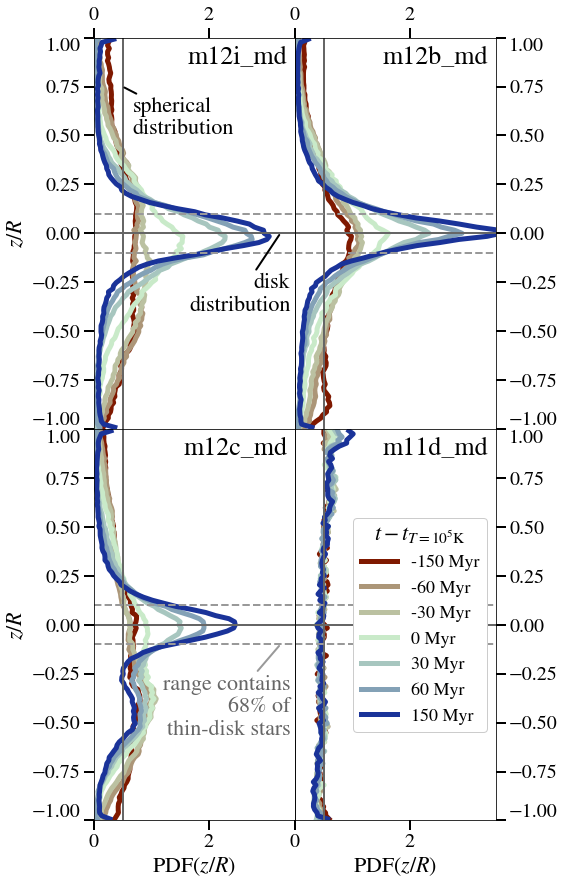

In [12]:
aspect = 2.
scale = 1.2

n_rows = len( sims_to_plot )
n_cols = len( sims_to_plot[0] )

fig = plt.figure( figsize=(3. * n_cols * scale, 6. * n_rows * scale), facecolor='w', )
fig.subplots_adjust( hspace=0.001, wspace=0.001 )
# main_ax = plt.gca()
ax_dict = fig.subplot_mosaic( sims_to_plot )

for k, row in enumerate( sims_to_plot ):

    for j, sim in enumerate( row ):

        ax = ax_dict[sim]

        pdfs = data['cosphi']['hist'][sim]
        centers = data['cosphi']['points'][sim]
        t_t1e5_centers = data['cosphi']['t_t1e5_centers'][sim]
        z_max = t_t1e5_centers.max()
        z_min = t_t1e5_centers.min()

        for i, pdf in enumerate( pdfs ):

            z_width = z_max - z_min
            color_value = ( t_t1e5_centers[i] - z_min )/z_width
            color = palettable.scientific.diverging.Roma_3.mpl_colormap( color_value )

            if np.isclose( t_t1e5_centers[i], 0. ):
                t_t1e5_centers[i] = 0
    #             label = (
    #                 r'$t - t_{T=10^5 {\rm K}}$ =' +
    #                 ' {:.3g}'.format( t_tphase_centers[i]*1e3 ) +
    #                 r' Myr'
    #             )
            label = (
                '{:.3g}'.format( t_t1e5_centers[i]*1e3 ) +
                r' Myr'
            )

            line = ax.plot(
                pdf,
                centers,
                linewidth = 5,
                color = color,
                label = label,
        #             zorder = 10 - i,
            )

        ax.tick_params(
            axis = 'both',
            top = ax.is_first_row(),
            labeltop = ax.is_first_row(),
            bottom = ax.is_last_row(),
            labelbottom = ax.is_last_row(),
            left = ax.is_first_col(),
            labelleft = ax.is_first_col(),
            right = ax.is_last_col(),
            labelright = ax.is_last_col(),
        )

        # Distribution curves
        ax.axvline(
            0.5,
            color = pm['background_linecolor'],
            linestyle = '-',
            linewidth = 2,
        )
#         ax.plot(
#             0.5 * np.sin( np.arccos( centers ) ),
#             np.arccos( centers ),
#         )
        ax.axhline(
            0.,
            color = pm['background_linecolor'],
            linestyle = '-',
            linewidth = 2,
        )
        
        # Comparison curves
        ax.axhline(
            pm['disk_costheta'],
            color = pm['lighter_background_linecolor'],
            linestyle = '--',
            linewidth = 2,
        )
        ax.axhline(
            -pm['disk_costheta'],
            color = pm['lighter_background_linecolor'],
            linestyle = '--',
            linewidth = 2,
        )
        if ax.is_last_row() and ax.is_first_col():
            ax.annotate(
                text = 'range contains\n68% of\nthin-disk stars',
                xy = ( 3.25, -pm['disk_costheta'] ),
                xycoords = 'data',
                xytext = ( 10, -30 ),
                textcoords = 'offset points',
                ha = 'right',
                va = 'top',
                fontsize = 22,
                arrowprops = {
                    'arrowstyle': '-',
                    'lw': 2,
                    'color': pm['lighter_background_linecolor'],
                },
                color = pm['background_linecolor'],
            )
        
        # Sim name label
        ax.annotate(
            text = sim,
            xy = ( 1, 1 ),
            xycoords = 'axes fraction',
            xytext = ( -7, -7 ),
            textcoords = 'offset points',
            ha = 'right',
            va = 'top',
            fontsize = 26,
        )
        
        ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
        ax.get_yticklabels()[-3].set_verticalalignment( 'top' )

        if ax.is_first_row() and ax.is_first_col():
            # line labels
            ax.annotate(
                text = 'spherical\ndistribution',
                xy = ( 0.5, 0.75 ),
                xycoords = 'data',
                xytext = ( 10, -10 ),
                textcoords = 'offset points',
                ha = 'left',
                va = 'top',
                fontsize = 22,
                arrowprops = {
                    'arrowstyle': '-',
                    'lw': 2,
                }
            )
            ax.annotate(
                text = 'disk\ndistribution',
                xy = ( 3.25, 0 ),
                xycoords = 'data',
                xytext = ( 10, -40 ),
                textcoords = 'offset points',
                ha = 'right',
                va = 'top',
                fontsize = 22,
                arrowprops = {
                    'arrowstyle': '-',
                    'lw': 2,
                }
            )

        if ax.is_last_row() and ax.is_last_col():
            ax.legend(
                prop={'size': 18},
                loc = 'center right',
                framealpha = 1,
                title = r'$t - t_{T=10^5 {\rm K}}$',
                title_fontsize = 22,
            )

        ax.set_xlim( 0, 3.5 )
        ax.set_ylim( -1., 1. )
#         ax.set_ylim( 0., np.pi )

        if ax.is_last_row():
            ax.set_xlabel( r'PDF$(z/R)$', fontsize=22 )

        if ax.is_first_col():
            ax.set_ylabel( r'$z/R$', fontsize=22 )
            
# plotting.save_fig(
#     out_dir = pm['figure_dir'],
#     save_file = 'theta_vs_t.pdf',
#     fig = fig,
# )

## Horizontal

File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/theta_vs_t.pdf


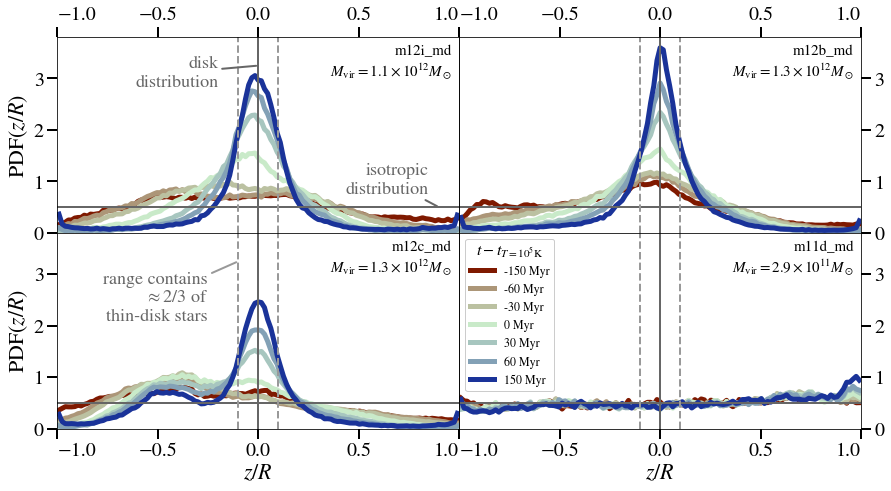

In [13]:
scale = 1.2

n_rows = len( sims_to_plot )
n_cols = len( sims_to_plot[0] )

fig = plt.figure( figsize=(6. * n_cols * scale, 3. * n_rows * scale), facecolor='w', )
fig.subplots_adjust( hspace=0.001, wspace=0.001 )
# main_ax = plt.gca()
ax_dict = fig.subplot_mosaic( sims_to_plot )

for k, row in enumerate( sims_to_plot ):

    for j, sim in enumerate( row ):

        ax = ax_dict[sim]

        pdfs = data['cosphi']['hist'][sim]
        centers = data['cosphi']['points'][sim]
        t_t1e5_centers = data['cosphi']['t_t1e5_centers'][sim]
        z_max = t_t1e5_centers.max()
        z_min = t_t1e5_centers.min()

        for i, pdf in enumerate( pdfs ):

            z_width = z_max - z_min
            color_value = ( t_t1e5_centers[i] - z_min )/z_width
            color = palettable.scientific.diverging.Roma_3.mpl_colormap( color_value )

            if np.isclose( t_t1e5_centers[i], 0. ):
                t_t1e5_centers[i] = 0
    #             label = (
    #                 r'$t - t_{T=10^5 {\rm K}}$ =' +
    #                 ' {:.3g}'.format( t_tphase_centers[i]*1e3 ) +
    #                 r' Myr'
    #             )
            label = (
                '{:.3g}'.format( t_t1e5_centers[i]*1e3 ) +
                r' Myr'
            )

            line = ax.plot(
                centers,
                pdf,
                linewidth = 5,
                color = color,
                label = label,
        #             zorder = 10 - i,
            )

        ax.tick_params(
            axis = 'both',
            top = ax.is_first_row(),
            labeltop = ax.is_first_row(),
            bottom = ax.is_last_row(),
            labelbottom = ax.is_last_row(),
            left = ax.is_first_col(),
            labelleft = ax.is_first_col(),
            right = ax.is_last_col(),
            labelright = ax.is_last_col(),
        )

        # Distribution curves
        ax.axhline(
            0.5,
            color = pm['background_linecolor'],
            linestyle = '-',
            linewidth = 2,
        )
#         ax.plot(
#             0.5 * np.sin( np.arccos( centers ) ),
#             np.arccos( centers ),
#         )
        ax.axvline(
            0.,
            color = pm['background_linecolor'],
            linestyle = '-',
            linewidth = 2,
        )
        
        # Comparison curves
        ax.axvline(
            pm['disk_costheta'],
            color = pm['lighter_background_linecolor'],
            linestyle = '--',
            linewidth = 2,
        )
        ax.axvline(
            -pm['disk_costheta'],
            color = pm['lighter_background_linecolor'],
            linestyle = '--',
            linewidth = 2,
        )
        if ax.is_last_row() and ax.is_first_col():
            ax.annotate(
                text = 'range contains\n' + r'$\approx 2/3$' + ' of\nthin-disk stars',
                xy = ( -pm['disk_costheta'], 3.25 ),
                xycoords = 'data',
                xytext = ( -30, -10 ),
                textcoords = 'offset points',
                ha = 'right',
                va = 'top',
                fontsize = 18,
                arrowprops = {
                    'arrowstyle': '-',
                    'lw': 2,
                    'color': pm['lighter_background_linecolor'],
                },
                color = pm['background_linecolor'],
            )
        
        # Sim name label
        sim_label = sim
        sim_label += '\n' + r'$M_{\rm vir}=' + py2tex.to_tex_scientific_notation( mvir[sim], 2 ) +  r'M_\odot$'
#         sim_label += '\n' + r'$f_{\rm thin\,disk,\,young}$ = ' + '{:.2g}'.format( data['thin_disk_fraction_recent'][sim] )
        ax.annotate(
            text = sim_label,
            xy = ( 1, 1 ),
            xycoords = 'axes fraction',
            xytext = ( -7, -7 ),
            textcoords = 'offset points',
            ha = 'right',
            va = 'top',
            fontsize = 15,
        )
        
        ax.get_xticklabels()[0].set_horizontalalignment( 'left' )
        ax.get_xticklabels()[-3].set_horizontalalignment( 'right' )

        if ax.is_first_row() and ax.is_first_col():
            # line labels
            ax.annotate(
                text = 'isotropic\ndistribution',
                xy = ( 0.9, 0.5 ),
                xycoords = 'data',
                xytext = ( -10, 10 ),
                textcoords = 'offset points',
                ha = 'right',
                va = 'bottom',
                fontsize = 18,
                arrowprops = {
                    'arrowstyle': '-',
                    'lw': 2,
                    'color': pm['background_linecolor'],
                },
                color = pm['background_linecolor'],
            )
            ax.annotate(
                text = 'disk\ndistribution',
                xy = ( 0, 3.25 ),
                xycoords = 'data',
                xytext = ( -40, 10 ),
                textcoords = 'offset points',
                ha = 'right',
                va = 'top',
                fontsize = 18,
                arrowprops = {
                    'arrowstyle': '-',
                    'lw': 2,
                    'color':  pm['background_linecolor'],
                },
                color = pm['background_linecolor'],
            )

        if ax.is_last_row() and ax.is_last_col():
            ax.legend(
                prop={'size': 12},
                loc = 'upper left',
                framealpha = 1,
                title = r'$t - t_{T=10^5 {\rm K}}$',
                title_fontsize = 16,
            )

        ax.set_xlim( -1., 1. )
        ax.set_ylim( 0, 3.8 )
#         ax.set_ylim( 0., np.pi )

        if ax.is_last_row():
            ax.set_xlabel( r'$z/R$', fontsize=22 )

        if ax.is_first_col():
            ax.set_ylabel( r'PDF$(z/R)$', fontsize=22 )
            
plotting.save_fig(
    out_dir = pm['figure_dir'],
    save_file = 'theta_vs_t.pdf',
    fig = fig,
)